In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [9]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score, recall_score,f1_score, confusion_matrix,roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
print(train.shape)
print(test.shape)

y = train['Survived']
train = train.drop(['Survived'], axis=1)

(891, 12)
(418, 11)


In [10]:
def preprocess_data(df, title_mapping=None, is_train=True):
    df = df.copy()

    df = df.drop(['Ticket'], axis=1)
    df['Age'] = df['Age'].fillna(df['Age'].median())

    df["Title"] = df["Name"].str.extract(r' ([A-Za-z]+)\.')

    if is_train:
        title_mapping = df['Title'].value_counts().to_dict() 
    df['Title'] = df['Title'].map(title_mapping) 
    df['Title'] = df['Title'].fillna(0)

    df['Deck'] = df['Cabin'].astype(str).str[0] 
    df["HasCabin"] = df["Cabin"].notnull().astype(int) 

    df['Fare'] = df['Fare'].fillna(df['Fare'].median())

    df = pd.get_dummies(df, columns=['Embarked', 'Sex', 'Deck'], drop_first=False)
    df = df.drop(['Name', 'Cabin'], axis=1)

    if is_train:
        return df, title_mapping
    else:
        return df

In [11]:
X, title_mapping = preprocess_data(train, is_train=True)
test = preprocess_data(test, title_mapping, is_train=False)


test = test.reindex(columns=X.columns, fill_value=0)


X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(test)


model = SVC(kernel='poly', C=10.0, gamma='scale', random_state=42)  
model.fit(X_train_scaled, y_train)


y_valid_pred = model.predict(X_valid_scaled)
y_test_pred = model.predict(X_test_scaled)


accuracy = accuracy_score(y_valid, y_valid_pred)
precision = precision_score(y_valid, y_valid_pred)
recall = recall_score(y_valid, y_valid_pred)
f1 = f1_score(y_valid, y_valid_pred)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print(train.shape)
print(test.shape)


Validation Accuracy: 0.8212
Precision: 0.7917
Recall: 0.7703
F1 Score: 0.7808
(891, 11)
(418, 22)


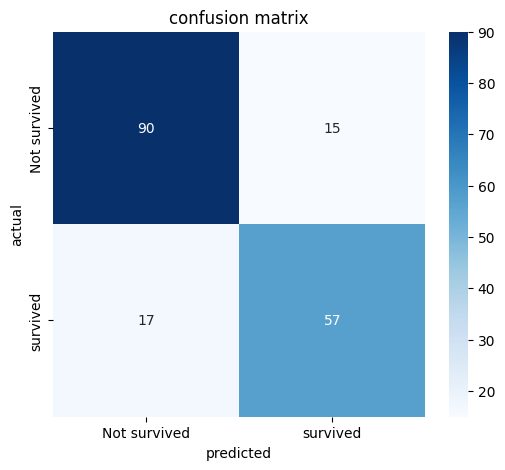

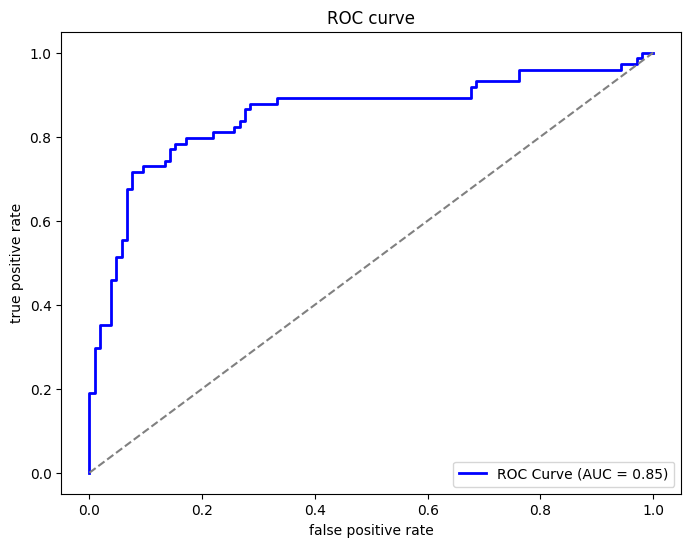

In [12]:
cm = confusion_matrix(y_valid, y_valid_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not survived', 'survived'], yticklabels=['Not survived', 'survived'])
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('confusion matrix')
plt.show()

y_valid_prob = model.decision_function(X_valid_scaled) 
fpr, tpr, _ = roc_curve(y_valid, y_valid_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='dashed')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [13]:
test = pd.read_csv("/kaggle/input/titanic/test.csv")
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],  
    "Survived": y_test_pred  
})

submission.to_csv("submission.csv", index=False)

print("Your submission was successfully saved!")

Your submission was successfully saved!
